# Source Restaurant Violations Data

## Imports 

In [19]:
# import pandas, numpy, matplotlib, seaborn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing the requests library
import requests

import urllib.request
from pathlib import Path
import os
import plotly.express as px

### Resources
 1. [Restaurants in Wake County Data Info](https://www.arcgis.com/home/item.html?id=124c2187da8c41c59bde04fa67eb2872)
 2. [Wake County Open Data](https://data-wake.opendata.arcgis.com/search?tags=restaurants)
 3. [Food Inspection Violations Data Info](https://data.wakegov.com/datasets/Wake::food-inspection-violations/about)
 4. [Wake County Yelp Initiative](https://ash.harvard.edu/news/wake-county-yelp-initiative)

## Fetching restaurant violations from wakegov

In [71]:
## only run this once, this takes a while ##
def getViolationsDf(forceFetch=False):
    path = Path()
    key = 'violations.csv'
    filename = path/key
    
    # If the file does already exist in the directory, download it
    if os.path.exists(filename) and not forceFetch:
        print('Using pre-fetched violations data...')
        df = pd.read_csv(key, dtype={'OBJECTID': 'int64',
         'HSISID': 'int64',
         'INSPECTDATE': 'object',
         'CATEGORY': 'object',
         'STATECODE': 'object',
         'CRITICAL': 'object',
         'QUESTIONNO': 'int64',
         'VIOLATIONCODE': 'object',
         'SEVERITY': 'object',
         'SHORTDESC': 'object',
         'INSPECTEDBY': 'object',
         'COMMENTS': 'object',
         'POINTVALUE': 'float64',
         'OBSERVATIONTYPE': 'object',
         'VIOLATIONTYPE': 'object',
         'CDCDATAITEM': 'object',
         'PERMITID': 'int64'}) # specify dtype to save some memory/time
        print('violations df shape:', df.shape)
        return df
    else:
        print('Fetching restaurant violations data...')
        val = 'https://opendata.arcgis.com/datasets/9b04d0c39abd4e049cbd4656a0a04ba3_2.geojson'
        rows = []
        r = requests.get(url = val)
        data = r.json()
        for d in data:
            data = r.json()['features']
            for d in data:
                rows.append(d['properties'])
        df = pd.DataFrame(rows)
        print('violations df shape:', df.shape)
        df.to_csv(key, index=False)
        print('Done')
        return df

violations_df = getViolationsDf(forceFetch=False)

Using pre-fetched violations data...
violations df shape: (1689108, 18)


# Preprocessing

In [72]:
violations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689108 entries, 0 to 1689107
Data columns (total 18 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   OBJECTID         1689108 non-null  int64  
 1   HSISID           1689108 non-null  int64  
 2   INSPECTDATE      1689108 non-null  object 
 3   CATEGORY         1689108 non-null  object 
 4   STATECODE        1689108 non-null  object 
 5   CRITICAL         1611268 non-null  object 
 6   QUESTIONNO       1689108 non-null  int64  
 7   VIOLATIONCODE    1689108 non-null  object 
 8   SEVERITY         1611268 non-null  object 
 9   SHORTDESC        1689108 non-null  object 
 10  INSPECTEDBY      1688796 non-null  object 
 11  COMMENTS         1686580 non-null  object 
 12  POINTVALUE       1689108 non-null  float64
 13  OBSERVATIONTYPE  1687840 non-null  object 
 14  VIOLATIONTYPE    899572 non-null   object 
 15  CDCRISKFACTOR    0 non-null        float64
 16  CDCDATAITEM      1

In [73]:
def preprocess_violations(df):
    
    other_cols_to_drop = ['QUESTIONNO', 'COMMENTS', 'COMMENTS', 'CDCDATAITEM', 'VIOLATIONCODE']
    # drop duplicates from dataframe
    df.drop_duplicates(inplace=True)
    
    # drop columns with high missing values
    df = df.drop('CDCRISKFACTOR', axis=1)
    
    # drop irrelevant column(s)
    df = df.drop('STATECODE', axis=1)
    
    # permit id is unique per rest so removing it
    df = df.drop('PERMITID', axis=1)
    
    # normalize observation type
    df['OBSERVATIONTYPE'] = df['OBSERVATIONTYPE'].str.upper()
    df['OBSERVATIONTYPE'].fillna('MISSING', inplace=True)
    
    # convert date to datetime & only get date
    df['INSPECTDATE'] = pd.to_datetime(df['INSPECTDATE']).dt.date
    
    # filter only since beginning of 2016 - we don't want data before that
    df = df[df['INSPECTDATE'] >= pd.to_datetime('2016-01-01').date()]
    
    df['CRITICAL'].fillna('No', inplace=True)
    
    df.drop(other_cols_to_drop, axis=1, inplace=True)
    
    return df

df = preprocess_violations(violations_df.copy()) # pass in copy for immutability
df.to_csv('preprocessed_violations.csv', index=False)
df.head()

,OBJECTID,HSISID,INSPECTDATE,CATEGORY,CRITICAL,SEVERITY,SHORTDESC,INSPECTEDBY,POINTVALUE,OBSERVATIONTYPE,VIOLATIONTYPE
10,190682112,4092016699,2017-03-24,Approved Source,No,NaN,Food obtained from approved source,Angela Myers,0.0,IN,NaN
11,190682241,4092030492,2021-06-14,Approved Source,No,NaN,Food obtained from approved source,David Adcock,1.0,OUT,NaN
12,190682242,4092017453,2017-10-18,Approved Source,No,NaN,Food obtained from approved source,Maria Powell,0.0,OUT,VR
13,190682243,4092015754,2017-11-15,Approved Source,No,NaN,Food obtained from approved source,Maria Powell,0.0,OUT,CDI
20,190682250,4092110015,2018-04-17,Approved Source,No,NaN,Food received at proper temperature,Laura McNeill,1.0,OUT,CDI


1.CDI = Corrected during inspection

2.NA = Not Applicable

3.NO = Not Observed

4.R = Repeat Violation

5.VR = Verification Required

## Validation

In [74]:
# critical(handled), severity, inspected by, comments, obs type, violation type, cdcdataitem
display(df.head())
print(df.shape)
print('VIOLATIONTYPE:', df['VIOLATIONTYPE'].unique())
print('OBSERVATIONTYPE:', df['OBSERVATIONTYPE'].unique())
print('CRITICAL:', df['CRITICAL'].unique())
print('CATEGORY:', df['CATEGORY'].unique())
print('SEVERITY', df['SEVERITY'].unique())
print('POINTVALUE', df['POINTVALUE'].unique())
print('CRITICAL COUNTS:', df['CRITICAL'].value_counts(dropna=False))

,OBJECTID,HSISID,INSPECTDATE,CATEGORY,CRITICAL,SEVERITY,SHORTDESC,INSPECTEDBY,POINTVALUE,OBSERVATIONTYPE,VIOLATIONTYPE
10,190682112,4092016699,2017-03-24,Approved Source,No,NaN,Food obtained from approved source,Angela Myers,0.0,IN,NaN
11,190682241,4092030492,2021-06-14,Approved Source,No,NaN,Food obtained from approved source,David Adcock,1.0,OUT,NaN
12,190682242,4092017453,2017-10-18,Approved Source,No,NaN,Food obtained from approved source,Maria Powell,0.0,OUT,VR
13,190682243,4092015754,2017-11-15,Approved Source,No,NaN,Food obtained from approved source,Maria Powell,0.0,OUT,CDI
20,190682250,4092110015,2018-04-17,Approved Source,No,NaN,Food received at proper temperature,Laura McNeill,1.0,OUT,CDI


(265671, 11)
VIOLATIONTYPE: [nan 'VR' 'CDI' 'R']
OBSERVATIONTYPE: ['IN' 'OUT' 'N/O' 'MISSING']
CRITICAL: ['No' 'Yes']
CATEGORY: ['Approved Source' 'Chemical' 'Conformance with Approved Procedures'
 'Consumer Advisory' 'Employee Health'
 'EQUIPMENT AND UTENSILS; PROTECTION FROM CONTAMINATION'
 'Food Identification' 'FOOD PROTECTION' 'Food Temperature Control'
 'Good Hygienic Practices' 'Highly Susceptible Populations'
 'LAUNDRY AND LINENS'
 'MANAGEMENT AND PERSONNEL; EMPLOYEE HEALTH; GOOD HYGIENE PRACTICES; PREVENTING CONTAMINATION BY HANDS'
 'PHYSICAL FACILITIES' 'Physical Facilities'
 'Potentially Hazardous Food Time/Temperature'
 'PREMISES, STORAGE, POISONOUS OR TOXIC MATERIALS'
 'Preventing Contamination by Hands' 'Prevention of Food Contamination'
 'Proper Use of Utensils' 'Protection from Contamination'
 'Safe Food and Water' 'Supervision' 'Utensils and Equipment'
 'WATER, PLUMBING AND WASTE']
SEVERITY [nan 'Core' 'Priority' 'Priority Foundation']
POINTVALUE [0.  1.  2.  0.5 1.5 3

In [75]:
display(df.isna().sum())
print(df.shape)
display(df.head())

OBJECTID                0
HSISID                  0
INSPECTDATE             0
CATEGORY                0
CRITICAL                0
SEVERITY            12132
SHORTDESC               0
INSPECTEDBY             0
POINTVALUE              0
OBSERVATIONTYPE         0
VIOLATIONTYPE      119380
dtype: int64

(265671, 11)


,OBJECTID,HSISID,INSPECTDATE,CATEGORY,CRITICAL,SEVERITY,SHORTDESC,INSPECTEDBY,POINTVALUE,OBSERVATIONTYPE,VIOLATIONTYPE
10,190682112,4092016699,2017-03-24,Approved Source,No,NaN,Food obtained from approved source,Angela Myers,0.0,IN,NaN
11,190682241,4092030492,2021-06-14,Approved Source,No,NaN,Food obtained from approved source,David Adcock,1.0,OUT,NaN
12,190682242,4092017453,2017-10-18,Approved Source,No,NaN,Food obtained from approved source,Maria Powell,0.0,OUT,VR
13,190682243,4092015754,2017-11-15,Approved Source,No,NaN,Food obtained from approved source,Maria Powell,0.0,OUT,CDI
20,190682250,4092110015,2018-04-17,Approved Source,No,NaN,Food received at proper temperature,Laura McNeill,1.0,OUT,CDI


In [76]:
print('OBSERVATIONTYPE:', df['OBSERVATIONTYPE'].unique())
display({column: len(df[column].unique()) for column in df.columns})

OBSERVATIONTYPE: ['IN' 'OUT' 'N/O' 'MISSING']


{'OBJECTID': 265671,
 'HSISID': 5381,
 'INSPECTDATE': 1642,
 'CATEGORY': 25,
 'CRITICAL': 2,
 'SEVERITY': 4,
 'SHORTDESC': 92,
 'INSPECTEDBY': 65,
 'POINTVALUE': 7,
 'OBSERVATIONTYPE': 4,
 'VIOLATIONTYPE': 4}

In [77]:
df.dtypes.apply(lambda x: x.name).to_dict()

{'OBJECTID': 'int64',
 'HSISID': 'int64',
 'INSPECTDATE': 'object',
 'CATEGORY': 'object',
 'CRITICAL': 'object',
 'SEVERITY': 'object',
 'SHORTDESC': 'object',
 'INSPECTEDBY': 'object',
 'POINTVALUE': 'float64',
 'OBSERVATIONTYPE': 'object',
 'VIOLATIONTYPE': 'object'}

In [119]:
ins = df.copy()

ins

INSPECTEDBY
Andrea Anover         12191
Angela Jacobs          4416
Angela Myers          13753
Anne Bartoli           1774
Ashley Whittington      207
                      ...  
Shannon Flynn          2354
Stephen Cogdell          21
Thomas Jumalon         6079
Ursula Gadomski        2969
Zachary Carter         1608
Length: 65, dtype: int64

In [122]:
disp = df.copy()
disp['INSPECTDATE'] =  pd.to_datetime(disp['INSPECTDATE'])
disp['Year'] = disp['INSPECTDATE'].dt.year
agg = disp.groupby(['Year']).size()
ins = disp.groupby(['INSPECTEDBY', 'Year']).size()
ins = pd.DataFrame(ins).reset_index()
ins.columns = ['Inspector', 'Year', '# of Violations']
agg = pd.DataFrame(agg).reset_index()
agg.columns = ['Year', '# of Violations']
display(ins)

,Inspector,Year,# of Violations
0,Andrea Anover,2016,4340
1,Andrea Anover,2017,3489
2,Andrea Anover,2018,4362
3,Angela Jacobs,2017,1250
4,Angela Jacobs,2018,2672
...,...,...,...
202,Ursula Gadomski,2020,1587
203,Ursula Gadomski,2021,1190
204,Zachary Carter,2019,165
205,Zachary Carter,2020,682


In [116]:
crit = disp.copy()
crit = crit[crit['CRITICAL'] == 'Yes']
crit = crit.groupby(['Year']).size()
crit = pd.DataFrame(crit).reset_index()
crit.columns = ['Year', '# of Critical Violations']

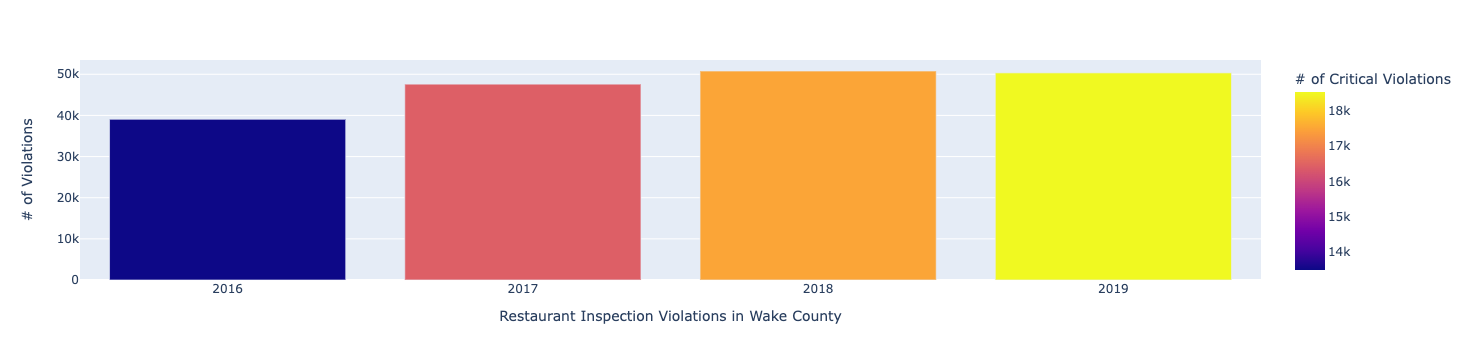

In [117]:
final = agg.merge(crit, on='Year', how='left')
final = final.loc[(final['Year'] == 2016) | (final['Year'] == 2017) | (final['Year'] == 2018) | (final['Year'] == 2019)]
fig = px.bar(final, x='Year', y='# of Violations',
             hover_data=['# of Critical Violations'], color='# of Critical Violations', height=200)

fig.update_xaxes(type='category', title='Restaurant Inspection Violations in Wake County')
fig.show()